In [1]:
import torch
import torch.nn as nn
import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pyro.infer import HMC, NUTS
from pyro.infer.mcmc import MCMC
import pdb
from src.models import HMC_vanilla


from tqdm import tqdm
%matplotlib inline

import sys
sys.path.insert(0, './src')
from data import Dataset
from layers import BBBLinear

In [4]:
import alpaca

ModuleNotFoundError: No module named 'alpaca'

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [4]:
class GMM():
    def __init__(self, device):
        self.loc_1 = torch.tensor([-5., 0.], dtype=torch.float32, device=device)
        self.covar_1 = torch.tensor([[1., 0.], [0., 1]], dtype=torch.float32, device=device)
        
        self.loc_2 = torch.tensor([5., 0.], dtype=torch.float32, device=device)
        self.covar_2 = torch.tensor([[1., 0.], [0., 1]], dtype=torch.float32, device=device)
        
        self.distr_1 = torch.distributions.MultivariateNormal(loc=self.loc_1, covariance_matrix=self.covar_1,)
        self.distr_2 = torch.distributions.MultivariateNormal(loc=self.loc_2, covariance_matrix=self.covar_2,)
        
        self.p = torch.tensor(0.5, dtype=torch.float32, device=device)
        self.bernoulli = torch.distributions.Bernoulli(probs=self.p)
        
    def log_prob(self, z, x=None):
        samples = z
        return torch.logsumexp(torch.cat([self.p.log() + self.distr_1.log_prob(samples)[None],
                                          (1. - self.p).log() + self.distr_2.log_prob(samples)[None]], dim=0), dim=0)
    
    def energy_function(self, init_params):
        z = init_params['points']
        return -self.log_prob(z)
    
    def sample(self, size):
        c = self.bernoulli.sample(size)[..., None]
        return c * self.distr_1.sample(size) + (1. - c) * self.distr_2.sample(size)
    
class Gaussian():
    def __init__(self, device):
        self.loc_1 = torch.tensor([-5., -2], dtype=torch.float32, device=device)
        self.covar_1 = torch.tensor([[1., 0.], [0., 1]], dtype=torch.float32, device=device)
        self.distr_1 = torch.distributions.MultivariateNormal(loc=self.loc_1, covariance_matrix=self.covar_1,)
        
    def log_prob(self, z, x=None):
        return self.distr_1.log_prob(z)
    
    def energy_function(self, init_params):
        return -self.distr_1.log_prob(z)
    
    def sample(self, size):
        return self.distr_1.sample(size)

In [5]:
target = GMM(device=device)

<ipython-input-6-655ec20b350a>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[0].pcolormesh(xx, yy, p, norm=mcolors.PowerNorm(0.5))


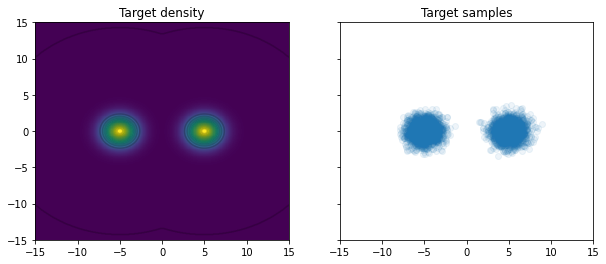

In [6]:
x_lim = 15
y_lim = 15
npts = 500

xside = np.linspace(-x_lim - 1, x_lim + 1, npts)
yside = np.linspace(-y_lim - 1, y_lim + 1, npts)
xx, yy = np.meshgrid(xside, yside)
z = torch.tensor(np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)]), device=device, dtype=torch.float32)
logdens = target.log_prob(z)
p = np.exp(logdens.cpu().detach().numpy().reshape(npts, npts))

fig, ax = plt.subplots(ncols=2, figsize=(10, 4), sharex=True, sharey=True)
ax[0].set_title('Target density')
ax[0].pcolormesh(xx, yy, p, norm=mcolors.PowerNorm(0.5))
ax[0].contour(xx, yy, p, 15, colors='black', alpha=0.2);
ax[0].set_xlim(-x_lim, x_lim)
ax[0].set_ylim(0, y_lim)
ax[0].set_xticks(np.arange(-x_lim, x_lim + 1, 5))
ax[0].set_yticks(np.arange(-y_lim, y_lim + 1, 5));

ax[1].set_title('Target samples')
samples = target.sample((5000, )).cpu().detach().numpy()
ax[1].scatter(samples[:, 0], samples[:, 1], alpha=0.075)
ax[1].set_xticks(np.arange(-x_lim, x_lim + 1, 5))
ax[1].set_yticks(np.arange(-y_lim, y_lim + 1, 5));

In [7]:
args = dotdict({})

args['device'] = device
args['torchType'] = torch.float32
args['N'] = 15
args['alpha'] = 0.5
args['gamma'] = 1.
args['use_partialref'] = False
args['use_barker'] = False

In [27]:
mu = nn.Parameter(torch.tensor([0., 0.], dtype=torch.float32, device=device))
logvar = nn.Parameter(torch.tensor([0., 0.], dtype=torch.float32, device=device))

L = 100
transition = HMC_vanilla(args)

params = [mu, logvar]
optimizer = torch.optim.Adam(params=params, lr=1e-1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

In [28]:
def compute_KL(mu, logvar, z):
    KL = (0.5 * (logvar + torch.exp(logvar) + mu ** 2 - 1.))
    return KL

def ELBO_vanilla(z, mu, logvar, target):
    return target.log_prob(z).mean() - compute_KL(mu, logvar, z).mean()

def VCD(z, mu, logvar, target):
#     pdb.set_trace()
    first_term = -ELBO_vanilla(z, mu, logvar, target)
    z_mcmc = run_mcmc(z.detach())
    second_term = -std_normal.log_prob((z_mcmc - mu) / torch.exp(0.5 * logvar)).mean() + ELBO_vanilla(z_mcmc, mu, logvar, target).detach() * std_normal.log_prob((z - mu) / torch.exp(0.5 * logvar)).mean()
    vcd = first_term + second_term
    return vcd

def run_mcmc_pyro(z):
    z_mcmc = torch.tensor([], device=device, dtype=torch.float32)
    for i in range(z.shape[0]):
        init_samples = z[i]
        init_params = {'points': init_samples}
        mcmc = MCMC(kernel=kernel, num_samples=1, warmup_steps=5, initial_params=init_params, disable_progbar=True)
        mcmc.run()
        z_mcmc = torch.cat([z_mcmc, mcmc._samples['points'].squeeze()[None]], dim=0)
    return z_mcmc

def run_mcmc(z):
    z_mcmc = z
    gamma = args.gamma
    for i in range(L):
        z_mcmc, _, _ = transition.make_transition(z_mcmc, None, target)
#         transition.gamma = torch.tensor(np.log(gamma), device=device)
#         gamma *= 0.975
    return z_mcmc

In [29]:
batch_size = 100
n_batches = 21
kernel = HMC(potential_fn=target.energy_function, num_steps=5,)

std_normal = torch.distributions.Normal(loc=torch.tensor(0., dtype=torch.float32, device=device),
                                       scale=torch.tensor(1., dtype=torch.float32, device=device))

  0%|          | 0/21 [00:00<?, ?it/s]

mu is Parameter containing:
tensor([ 0.1000, -0.1000], requires_grad=True)
logvar is Parameter containing:
tensor([ 0.1000, -0.1000], requires_grad=True)


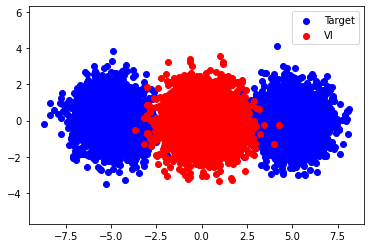

 48%|████▊     | 10/21 [00:10<00:11,  1.06s/it]

mu is Parameter containing:
tensor([ 0.7714, -0.0276], requires_grad=True)
logvar is Parameter containing:
tensor([ 1.0410, -1.0463], requires_grad=True)


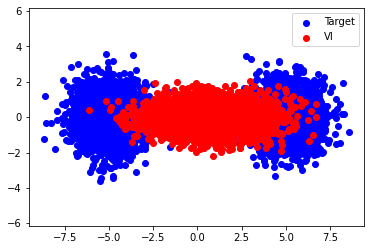

 95%|█████████▌| 20/21 [00:21<00:01,  1.06s/it]

mu is Parameter containing:
tensor([1.4163, 0.0358], requires_grad=True)
logvar is Parameter containing:
tensor([ 1.7121, -1.7637], requires_grad=True)


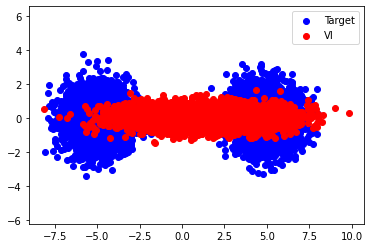

100%|██████████| 21/21 [00:22<00:00,  1.08s/it]


In [30]:
for b_num in tqdm(range(n_batches)):
    plt.close()
    batch = target.sample((batch_size, ))
    eps = std_normal.sample(batch.shape)
    z = mu + eps * torch.exp(logvar * 0.5)
    vcd = VCD(z, mu, logvar, target)
    vcd.backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step()
    if b_num % 10 == 0:
        print(f'mu is {mu}')
        print(f'logvar is {logvar}')
        samples_target = target.sample((5000, )).cpu().detach().numpy()
        samples_vi = (mu + std_normal.sample((5000, 2)) * torch.exp(0.5 * logvar)).cpu().detach().numpy()
        plt.scatter(samples_target[:, 0], samples_target[:, 1], label='Target', c='b')
        plt.scatter(samples_vi[:, 0], samples_vi[:, 1], label='VI', c='r')
        plt.legend()
        plt.axis('equal')
        plt.show()

### Visualisation of final samples

In [31]:
mu_vcd = mu.detach()
logvar_vcd = logvar.detach()

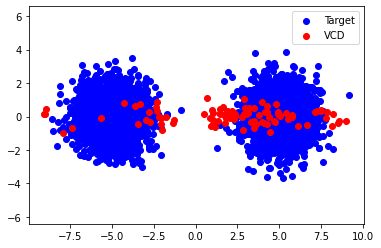

In [32]:
batch = target.sample((batch_size, ))
eps = std_normal.sample(batch.shape)
z = mu + eps * torch.exp(logvar * 0.5)
z_vcd = run_mcmc(z.detach())
samples_target = target.sample((5000, )).cpu().detach().numpy()
samples_vi = z_vcd.cpu().detach().numpy()
plt.scatter(samples_target[:, 0], samples_target[:, 1], label='Target', c='b')
plt.scatter(samples_vi[:, 0], samples_vi[:, 1], label='VCD', c='r')
plt.legend()
plt.axis('equal')
plt.show()

### Last Layer NN

In [12]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [13]:
def set_seeds(rand_seed):
    torch.backends.cudnn.deterministic = True
    torch.cuda.set_device(device)
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(rand_seed)
    np.random.seed(rand_seed)
    random.seed(rand_seed)
    torch.cuda.manual_seed_all(rand_seed)

set_seeds(1337)

In [14]:
args = dotdict({})

args['device'] = device
args['torchType'] = torch.float32
args['dataset_name'] = 'boston_housing'
if args['dataset_name'].find('mnist') > -1:
    args['num_epoches'] = 201
    args['print_info'] = 50
    args['n_IS'] = 10000
    
    args['train_batch_size'] = 100
    args['val_dataset'] = 10000
    args['val_batch_size'] = 100
    args['test_batch_size'] = 100
else:
    args['n_IS'] = 1000
    args['num_epoches'] = 10001
    args['print_info'] = 1000
    args['train_batch_size'] = 100
    args['val_dataset'] = 100
    args['val_batch_size'] = 20
    args['test_batch_size'] = 10

In [ ]:
def load_parameters(model, param_vector, params_shapes):
    left_boader = 0
    tensors = []
    for shape in params_shapes:
        cur_len = np.prod(shape)
        tensors.append(param_vector[left_boader: left_boader+cur_len].view(*shape))
        left_boader += cur_len
    d = OrderedDict()
    model_clone = copy.deepcopy(model)
    for i, name in enumerate(model_clone.layer3.named_parameters()):
        d[name[0]] = tensors[i]
    model_clone.load_state_dict(d)
    model_clone.to(model.device)
    return model_clone

In [55]:
class LastLayerBNN(nn.Module):
    def __init__(self, in_features, last_features=10, aux={}):
        super().__init__()
        
        self.layer1 = nn.Linear(in_features, 4*in_features)
        self.layer2 = nn.Linear(4*in_features, last_features)
        self.layer3 = BBBLinear(last_features, 1, aux=aux)
        self.device = aux.device
        self.std_normal = torch.distributions.Normal(loc=torch.tensor(0., dtype=torch.float32, device=self.device),
                                             scale=torch.tensor(1., dtype=torch.float32, device=self.device))

    def get_kl(self):
        return self.layer3.get_kl()

    def forward(self, input, sample=True):
        h = F.softplus(self.layer1(input))
        h = F.softplus(self.layer2(h))
        h = self.layer3(h, sample=sample)
        
    def log_prob(self, x, z):
        '''
        x - data vector
        z - vector of all parameters
        '''
        log_prior = sum([self.std_normal.log_prob(p).sum() for p in self.layer3.parameters()])
        pdb.set_trace()
        loaded_model = load_parameters(self, z[0], [p.shape for p in model.layer3.parameters()])
        y_pred = loaded_model(x)
        log_likelihood = self.std_normal.log_prob(y_pred - dataset.y_train).sum()
        logdensity = log_likelihood + log_prior
        return logdensity[None]
        
        return h

In [56]:
dataset = Dataset(args)
dataset.in_features[0]

Train data shape 406


/home/nkotelevskii/anaconda3/envs/condatorch/lib/python3.7/site-packages/alpaca/dataloader/boston_housing.py:37: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  self.df = pd.read_table(data_path, names=self.column_names, header=None, delim_whitespace=True)


13

In [57]:
def compute_KL(mu, logvar, z):
    KL = (0.5 * (logvar + torch.exp(logvar) + mu ** 2 - 1.))
    return KL

def ELBO_vanilla(z, model, target):
    return target.log_prob(z).sum() - model.get_kl()

def VCD(z, mu, logvar, target):
#     pdb.set_trace()
    first_term = -ELBO_vanilla(z, mu, logvar, target)
    z_mcmc = run_mcmc(z.detach())
    second_term = -std_normal.log_prob((z_mcmc - mu) / torch.exp(0.5 * logvar)).mean() + ELBO_vanilla(z_mcmc, mu, logvar, target).detach() * std_normal.log_prob((z - mu) / torch.exp(0.5 * logvar)).mean()
    vcd = first_term + second_term
    return vcd

def run_mcmc(z):
    z_mcmc = z
    gamma = args.gamma
    for i in range(L):
        z_mcmc, _, _ = transition.make_transition(z_mcmc, None, target)
    return z_mcmc

In [58]:
model = LastLayerBNN(in_features=dataset.in_features[0], aux=args).to(device) #,  'var_family_type': 'IAF'

In [60]:
torch.prod(torch.tensor())

ValueError: only one element tensors can be converted to Python scalars

In [52]:
model.log_prob(dataset.x_train, )

> <ipython-input-48-529ad1f9e151>(26)log_prob()
-> log_prior = sum([self.std_normal.log_prob(p).sum() for p in self.layer3.parameters()])


(Pdb)  n


> <ipython-input-48-529ad1f9e151>(27)log_prob()
-> loaded_model = load_parameters(self, z[0], params_shapes)


(Pdb)  log_prior


tensor(-26.7129, device='cuda:0', grad_fn=<AddBackward0>)


(Pdb)  q


BdbQuit: 

In [ ]:
params = list(model.parameters())
optimizer = torch.optim.Adam(params, lr=1e-1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.75)

best_mse = float('inf')
best_KL = float('inf')
current_tol = 0


for ep in tqdm(range(args.num_epoches)):
    for x_train, y_train_labels in dataset.next_train_batch():
        preds = model(x_train)
        
        log_likelihood = torch.distributions.Normal(loc=preds, scale=torch.tensor(1., device=device,
                                                                                  dtype=args.torchType)).log_prob(y_train_labels).sum()
        
        first_term = -ELBO_vanilla(z, model, target)
        z_mcmc = run_mcmc(z.detach())
        second_term = -std_normal.log_prob((z_mcmc - mu) / torch.exp(0.5 * logvar)).mean() + ELBO_vanilla(z_mcmc, mu, logvar, target).detach() * std_normal.log_prob((z - mu) / torch.exp(0.5 * logvar)).mean()
        vcd = first_term + second_term
        vcd.backward()

        optimizer.step()
        optimizer.zero_grad()
    scheduler.step()
    if ep % args.print_info == 0:
        print(f'ELBO value is {elbo.cpu().detach().numpy()} on epoch number {ep}')
        score_total = []
        with torch.no_grad():
            for x_val, y_val_labels in dataset.next_val_batch():
                logits = model(x_val)
                score = ((logits - y_val_labels)**2).mean().cpu().numpy()
                score_total.append(score)
        print(f"Mean validation MSE at epoch number {ep} is {np.array(score_total).mean()}")
        print(f'Current KL is {KL.cpu().detach().numpy()}')